In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization, Activation, Add, Dropout, DepthwiseConv2D
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [2]:
import tensorflow.keras.backend as K
import gc
from keras import optimizers
from tqdm.notebook import tqdm_notebook

In [3]:
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.4.0


# LOAD DATA

In [4]:
# ------------------------------------------------------------------------------- #
#                              Important Variables                                #
# ------------------------------------------------------------------------------- #
data_dir = "../DL_data/competition_data"
validation_data_dir = "../DL_data/competition_data"
nrows = "all"                 # Set to 'all' to load the whole set
load_validation = True      # Only load the validation images and masks??
split_train_test = False    # Split data to train and test sets??
data_augmentation = False   # Augment the data??
# ------------------------------------------------------------------------------- #


#load the ids  and depths of 'nrows' from the training data set
if isinstance(nrows, int) and nrows>0:
    train_df = pd.read_csv(data_dir+"/train.csv", index_col="id", usecols=[0], nrows=nrows)
    depths_df = pd.read_csv(data_dir+"/depths.csv", index_col="id")
    train_df = train_df.join(depths_df)
    test_df = depths_df[~depths_df.index.isin(train_df.index)]
elif isinstance(nrows, str) and nrows.upper() == "ALL":
    train_df = pd.read_csv(data_dir+"/train.csv", index_col="id", usecols=[0])
    depths_df = pd.read_csv(data_dir+"/depths.csv", index_col="id")
    train_df = train_df.join(depths_df)
    test_df = depths_df[~depths_df.index.isin(train_df.index)]
else:
    raise ValueError("Invalid nrows value")
        

        
# Function that loads the ids of 'nrows' from the validation data set
def load_validation_data(data_dir, nrows):
    if isinstance(nrows, int) and nrows>0:
        valid_ids = pd.read_csv(data_dir+"/Validation_ids.csv", usecols=[1], nrows=nrows)
    elif isinstance(nrows, str) and nrows.upper() == "ALL":
        valid_ids = pd.read_csv(data_dir+"/Validation_ids.csv")
    else:
        raise ValueError("Invalid nrows value")
    return valid_ids.ids

In [5]:
if load_validation:
    ids_to_load = load_validation_data(data_dir, nrows)
    index_list = list(train_df.index)
    ids_list = [index_list.index(i) for i in ids_to_load]
    train_df = train_df.iloc[ids_list]
else:
    ids_to_load = train_df.index
    
print("Loading images...")
train_df["images"] = [np.array(load_img(data_dir+"/train/images/{}.png".format(idx),
                                        color_mode = "grayscale"))/255 for idx in tqdm_notebook(list(ids_to_load))]
print("Loading masks...")
train_df["masks"] = [np.array(load_img(data_dir+"/train/masks/{}.png".format(idx),
                                       color_mode = "grayscale"))/65535 for idx in tqdm_notebook(list(ids_to_load))] 
 #train_df.index

print("done loading images")

Loading images...


  0%|          | 0/800 [00:00<?, ?it/s]

Loading masks...


  0%|          | 0/800 [00:00<?, ?it/s]

done loading images


In [6]:
# -------------> data example
# printing
print("-------------------------------------------------------------")
id = '2a070f3dc6'
id_index = np.where(train_df.index == id)
id_index = id_index[0][0]
print("id_index = ", id_index)
image = train_df["images"][id]
print(image)
print(image.shape)
print("-------------------------------------------------------------")
mask = train_df["masks"][id]
print(mask)
print(mask.shape)

-------------------------------------------------------------
id_index =  797
[[0.36078431 0.36078431 0.36862745 ... 0.19607843 0.23529412 0.26666667]
 [0.36078431 0.36470588 0.37647059 ... 0.25490196 0.2745098  0.2745098 ]
 [0.36078431 0.37254902 0.38039216 ... 0.31372549 0.29803922 0.27843137]
 ...
 [0.36470588 0.37254902 0.38039216 ... 0.4        0.39607843 0.39215686]
 [0.36862745 0.37647059 0.38039216 ... 0.39607843 0.39607843 0.39215686]
 [0.37254902 0.38039216 0.38039216 ... 0.39607843 0.39607843 0.39607843]]
(101, 101)
-------------------------------------------------------------
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(101, 101)


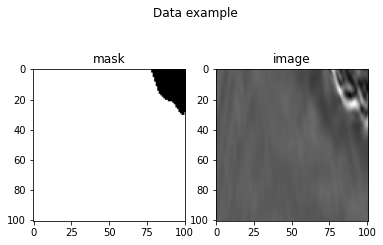

In [7]:
def plot_image_example():
    fig_imgshow, (axs_mask, axs_img) = plt.subplots(1, 2)
    fig_imgshow.suptitle("Data example")
    axs_img.imshow(np.dstack((image, image, image)))  # interpolation='nearest'
    axs_img.set(title="image")
    tmp = np.squeeze(mask).astype(np.float32)
    axs_mask.imshow(np.dstack((tmp, tmp, tmp)))
    axs_mask.set(title="mask")


plot_image_example()

# **Prepossessing Data**

#### ------> Resize to a pow of 2

In [8]:
# either pad with zeros or resize with interpolation
resize_to = 128
original_size = 101


def upsample(original_img):
    if resize_to == original_size:
        return original_img
    return resize(original_img, (resize_to, resize_to), mode='constant', preserve_range=True)


def pad_zeros(array):
    padded_image = np.zeros(shape=(resize_to, resize_to))
    padded_image[13:114, 13:114] = array
    return padded_image

In [9]:
resizing_function_to_use = pad_zeros

images_resized = np.array(train_df.images.map(resizing_function_to_use).tolist()).reshape((-1, resize_to, resize_to, 1))
masks_resized = np.array(train_df.masks.map(resizing_function_to_use).tolist()).reshape((-1, resize_to, resize_to, 1))

In [ ]:
# Plotting
def plot_reshape_example():
    fig_reshape, (axs_reshape_mask, axs_reshape_img) = plt.subplots(1, 2)
    fig_reshape.suptitle("Reshaped data example")
    axs_reshape_img.set(title="Reshaped image")
    axs_reshape_mask.set(title="Reshaped mask")
    axs_reshape_img.imshow(images_resized[id_index], cmap='gray')
    axs_reshape_mask.imshow(masks_resized[id_index], cmap='gray')


plot_reshape_example()

#### -----> Calculating the salt coverage

In [10]:
train_df["coverage"] = train_df.masks.map(np.sum) / (train_df["masks"][0].shape[0]*train_df["masks"][0].shape[1])

# Generate salt coverage classes
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Plotting the salt coverage classes

Text(0.5, 0, 'Coverage class')

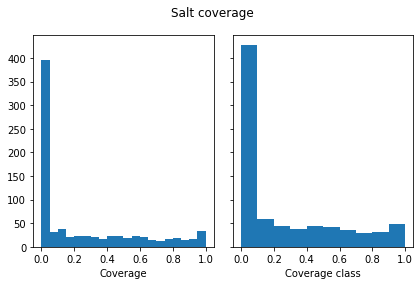

In [11]:
#TO_DO: Change that to use matplotlib
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins = 20
axs[0].hist(train_df.coverage, bins=n_bins)
axs[1].hist(train_df.coverage, bins=10)

plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

#### ------> Split train/dev

In [12]:
if split_train_test:
    (ids_train, ids_valid, x_train, x_valid, y_train, y_valid,
     cov_train, cov_test, depth_train, depth_test) = train_test_split(train_df.index.values, 
                                                                      images_resized, masks_resized, 
                                                                      train_df.coverage.values, 
                                                                      train_df.z.values, 
                                                                      test_size=0.2, 
                                                                      stratify=train_df.coverage_class,
                                                                      random_state=1337)
else:
    x_train = images_resized
    y_train = masks_resized
    x_valid = np.array([])  # Just to print the x_valid.shape([0]) in the end
    y_valid = np.array([]) 

print("Train/ Valid shape = %d/ %d"%(x_train.shape[0], x_valid.shape[0]))

Train/ Valid shape = 800/ 0


In [ ]:
#print(ids_valid.shape)
#ids = {"ids": list(ids_valid)}
#df = pd.DataFrame(ids) # .to_csv("../DL_data/competition_data/Validation_ids.csv")
#df.to_csv("../DL_data/competition_data/Validation_ids.csv")

#### ------> Data augmentation

In [13]:
if data_augmentation:
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [14]:
x_train = np.repeat(x_train,3,axis=3)

In [15]:
print("x_rain shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_rain shape:  (800, 128, 128, 3)
y_train shape:  (800, 128, 128, 1)


# U-Net

#### -----> IoU metric

In [16]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    #print("A shape: ", A.shape)
    #print("B shape: ", B.shape)
    metric = 0.0
    for batch in range(batch_size):
        
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        #print("True: ", t)
        #print("Predicted: ", p)
        #print("----------------------")
        #print("True sum: ", true)
        #print("Predicted sum: ", pred)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # Scale the iou function: iou -> 2*iou - 0.9
        # This will map the threshold values [0.5, 0.55, 0.6, ...., 0.9] to the
        # values [0.1, 0.2, 0.3, ....., 0.9]. Then multiply 2*iou - 0.9 by 10 and floor.
        # This will map the iou values to the number of thresholds that the iou sutisfies
        # witch is what we are intreasted in in the first playse.
        # For example if iou=0.552 then floor(2*iou - 0.9)*10 = 2. Since
        # eveery value <0 means an original value<0.5 we take the max with 0. Finaly we 
        # devide by 10 = |threshods|.
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.compat.v1.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

#### ------> Additional blocks

In [17]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

def block(block_in, expand_filters, project_filters, depthwise_stride=(1, 1), depthwise_padding="same", 
          zero_padding=False):
    x = convolution_block(block_in, expand_filters, (1, 1))
    
    #if zero_padding:
    #    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    #x = DepthwiseConv2D((3,3), strides=(1, 1), padding=depthwise_padding)(x)
    #x = BatchActivate(x)
    
    x = convolution_block(x, expand_filters, (3, 3))
    
    x = convolution_block(x, project_filters, (1, 1), activation = True)
    # x = BatchNormalization()(x)
    return x


def transpose_block(block_in, to_add, expand_filters, project_filters):
    x = convolution_block(block_in, expand_filters, (1, 1))
    x = BatchActivate(x)
    
    x = Conv2DTranspose(expand_filters, (3,3), strides=(2, 2), padding="same")(x)
    x = concatenate([x, to_add])
    print("after concatenate = ", x.shape)
    x = BatchActivate(x)
    
    x = convolution_block(x, project_filters, (1, 1), activation = True)
    #x = BatchNormalization()(x)
    return x
    

def res_block_1(block_in, expand_filters, project_filters):
    block1 = block(block_in, expand_filters, project_filters)
    block1 = Add()([block1, block_in])
    return block1


def res_block_2(block_in, first_block_filters, second_block_filters, block1_strides=(1, 1),
                block1_padding="same",
                block1_zero_padding=False):
    x = block1(block_in, first_block_filters[0], first_block_filters[1], depthwise_stride=block1_strides, 
               depthwise_padding=block1_padding, 
               zero_padding=block1_zero_padding)
    
    x = block2(x, second_block_filters[0], second_block_filters[1])
    
    x = Add()([x, block_in])
    return x
    

    

##### -----> Model definition

In [18]:
input_shape = (128, 128, 3)

backbone = MobileNetV2(input_shape=input_shape,weights='imagenet',include_top=False)
inputs = backbone.input

# conv4 = backbone.output

In [19]:
print(backbone.summary())

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
layer = backbone.get_layer('block_13_depthwise')
print(layer)
print(layer.strides)
print(layer.padding)
print(layer.kernel_size)

In [ ]:
layer = backbone.get_layer('block_6_pad')
print(layer)
print(layer.padding)

In [21]:
start_neurons = 16
DropoutRatio = 0.5

print("START BUILDING MODEL")

#input_layer = Input(input_shape)
#print("BUILD INPUT")

middle_1 = backbone.get_layer('block_13_expand_BN')
middle_1 = middle_1.output
#conv4 = LeakyReLU(alpha=0.1)(conv4)
#pool4 = MaxPooling2D((2, 2))(conv4)
#pool4 = Dropout(0.1)(pool4)
print("middle_1.shape = ", middle_1.shape)
    
# Middle
filters_m = 384
convm = Conv2D(filters_m, (3, 3), activation=None, padding="same")(middle_1)
convm = residual_block(convm,filters_m)
convm = residual_block(convm,filters_m, True)
print("convm.shape = ", convm.shape)


    

#8 -> 16
print("--------------------------------------------------------")
expand_filters_1 = 576
project_filters_1 = 160
to_add_1 = backbone.get_layer('block_6_expand_BN')
to_add_1 = to_add_1.output

uconv1_1 = transpose_block(convm, to_add_1, 192, 64)
uconv1_2 = block(uconv1_1, 384, 64)
uconv1_add_1 = Add()([uconv1_1, uconv1_2])
uconv1_3 = block(uconv1_add_1, 384, 64)
uconv1_add_2 = Add()([uconv1_add_1, uconv1_3])

print("uconv1_1.shape = ", uconv1_1.shape)
print("uconv1_2.shape = ", uconv1_2.shape)
print("uconv1_add_2.shape = ", uconv1_add_2.shape)



#8 -> 8
#print("--------------------------------------------------------")
#expand_filters_h = 576
#project_filters_h = 160

#hconv1_1 = block(uconv1_add_2, 384, 96)
#hconv1_2 = block(hconv1_1, 576, 96)
#hconv1_add_1 = Add()([hconv1_1, hconv1_2])
#hconv1_3 = block(hconv1_add_1, 576, 96)
#hconv1_add_2 = Add()([hconv1_add_1, hconv1_3])

#print("hconv1_1.shape = ", hconv1_1.shape)
#print("hconv1_2.shape = ", hconv1_2.shape)
#print("hconv1_add_2.shape = ", hconv1_add_2.shape)



#16 -> 32
print("--------------------------------------------------------")
expand_filters_2 = 192
project_filters_2 = 64
to_add_2 = backbone.get_layer('block_3_expand_BN')
to_add_2 = to_add_2.output

uconv2_1 = transpose_block(uconv1_add_2, to_add_2, 144, 32)
uconv2_2 = block(uconv2_1, 192, 32)
uconv2_add_1 = Add()([uconv2_1, uconv2_2])
uconv2_3 = block(uconv2_add_1, 192, 32)
uconv2_add_2 = Add()([uconv2_add_1, uconv2_3])

print("uconv2_1.shape = ", uconv2_1.shape)
print("uconv2_2.shape = ", uconv2_2.shape)
print("uconv2_add_2.shape = ", uconv2_add_2.shape)



#32 -> 64
print("--------------------------------------------------------")
expand_filters_3 = 144
project_filters_3 = 32
to_add_3 = backbone.get_layer('expanded_conv_project_BN')
to_add_3 = to_add_3.output

uconv3_1 = transpose_block(uconv2_add_2, to_add_3, 92, 24)
uconv3_2 = block(uconv3_1, 144, 24)
uconv3_add_1 = Add()([uconv3_1, uconv3_2])
uconv3_3 = block(uconv3_add_1, 144, 24)
uconv3_add_2 = Add()([uconv3_add_1, uconv3_3])

print("uconv3_1.shape = ", uconv3_1.shape)
print("uconv3_2.shape = ", uconv3_2.shape)
print("uconv3_add_2.shape = ", uconv3_add_2.shape)



#32 -> 64
#print("--------------------------------------------------------")
#expand_filters_4 = 96
#project_filters_4 = 24
#to_add_4 = backbone.get_layer('block_1_expand_BN')
#to_add_4 = to_add_4.output

#uconv4_1 = transpose_block(uconv3_add_2, to_add_4, expand_filters_4, project_filters_4)
#uconv4_2 = block(uconv4_1, expand_filters_4, project_filters_4)
#uconv4_add_1 = Add()([uconv4_1, uconv4_2])
#uconv4_3 = block(uconv4_add_1, expand_filters_4, project_filters_4)
#uconv4_add_2 = Add()([uconv4_add_1, uconv4_3])

#print("uconv4_1.shape = ", uconv4_1.shape)
#print("uconv4_2.shape = ", uconv4_2.shape)
#print("uconv4_add_2.shape = ", uconv4_add_2.shape)



#64 -> 128
print("--------------------------------------------------------")
filters_5 = 8
deconv0 = Conv2DTranspose(filters_5, (3, 3), strides=(2, 2), padding="same")(uconv3_add_2)
print("deconv0 = ", deconv0.shape)
# to_add_6 = backbone.get_layer("expanded_conv_project_BN")
# to_add_6 = to_add_6.output
# uconv0 = concatenate([deconv0, to_add_6])
# print("uconv0 after concatenate = ", uconv0.shape)
    
uconv0 = Dropout(DropoutRatio)(deconv0)
uconv0 = Conv2D(filters_5, (3, 3), activation=None, padding="same")(uconv0)
uconv0 = residual_block(uconv0,filters_5)
uconv0 = residual_block(uconv0,filters_5, True)
print("uconv0 = ", uconv0.shape)
    
#uconv1 = Dropout(DropoutRatio/2)(uconv1)
#output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv0)
output_layer =  Activation('sigmoid')(output_layer_noActi)
print("output_layer = ", output_layer.shape)

START BUILDING MODEL
middle_1.shape =  (None, 8, 8, 576)
convm.shape =  (None, 8, 8, 384)
--------------------------------------------------------
after concatenate =  (None, 16, 16, 384)
uconv1_1.shape =  (None, 16, 16, 64)
uconv1_2.shape =  (None, 16, 16, 64)
uconv1_add_2.shape =  (None, 16, 16, 64)
--------------------------------------------------------
after concatenate =  (None, 32, 32, 288)
uconv2_1.shape =  (None, 32, 32, 32)
uconv2_2.shape =  (None, 32, 32, 32)
uconv2_add_2.shape =  (None, 32, 32, 32)
--------------------------------------------------------
after concatenate =  (None, 64, 64, 108)
uconv3_1.shape =  (None, 64, 64, 24)
uconv3_2.shape =  (None, 64, 64, 24)
uconv3_add_2.shape =  (None, 64, 64, 24)
--------------------------------------------------------
deconv0 =  (None, 128, 128, 8)
uconv0 =  (None, 128, 128, 8)
output_layer =  (None, 128, 128, 1)


In [22]:
model = Model(inputs=[inputs], outputs=[output_layer])
print("BUILD MODEL")
adam_optimizer = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=[my_iou_metric])
print("COMPILE")
model.summary()

BUILD MODEL
COMPILE
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________

#### -----> Training

In [23]:
epochs = 20
batch_len = 4
history = model.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_len)

Epoch 1/20
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
200/200 [==============================] - 57s 233ms/step - loss: 0.4004 - my_iou_metric: 0.1599
Epoch 2/20
200/200 [==============================] - 46s 231ms/step - loss: 0.2501 - my_iou_metric: 0.3578
Epoch 3/20
200/200 [==============================] - 53s 267ms/step - loss: 0.2386 - my_iou_metric: 0.3614
Epo

#### Plotting model results and cleaning up

In [24]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        print(len(hs[label].history['loss']))
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        # plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()
    
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


20


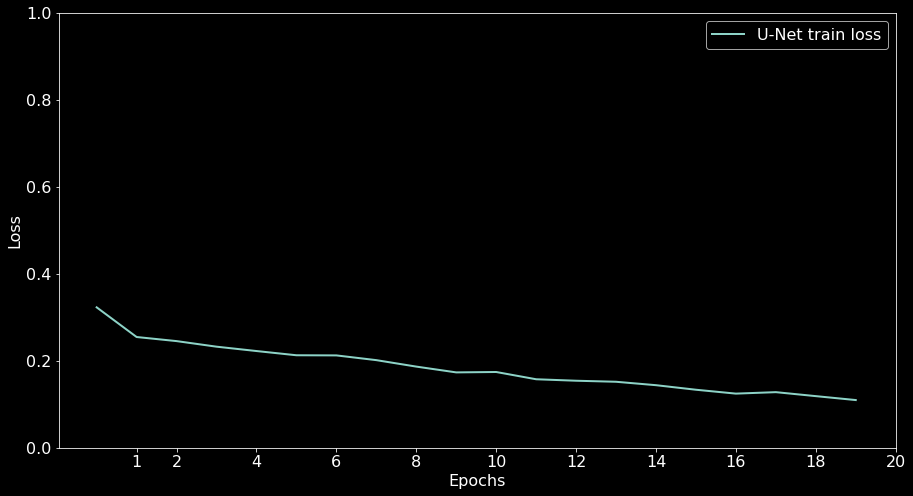


20


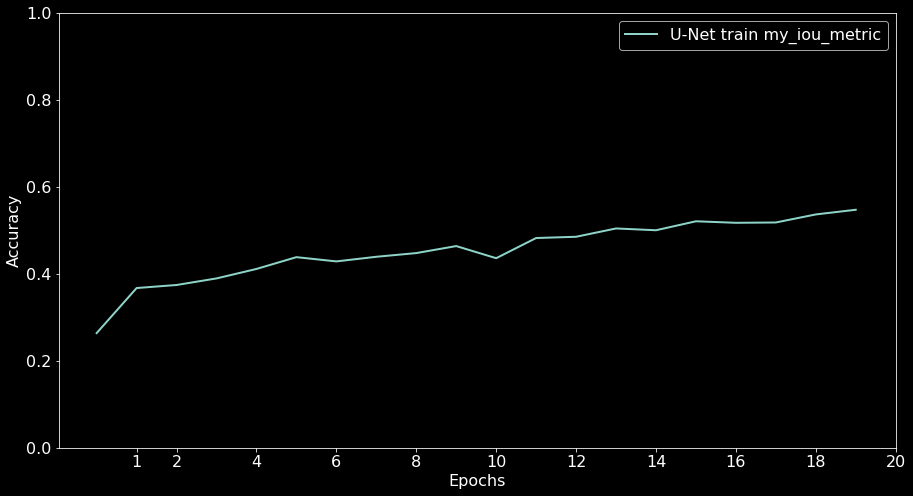

In [25]:
plot_history(hs={'U-Net': history}, epochs=epochs, metric='loss')
plot_history(hs={'U-Net': history}, epochs=epochs, metric='my_iou_metric')

In [ ]:
clean_up(model)